## MODELOS DE LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR PETROLERO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos la data de Demanda de gas en sector petrolero como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Se lee la data "original" de Demanda en sector eléctrico

In [2]:
csv_demanda_petrolero_original = pd.read_csv('Demanda_petrolero_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_petrolero_original

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2022-05-01,1919.43
2022-06-01,1876.88
2022-07-01,1979.70


Se grafica la data "original" de Demanda en sector petrolero

Text(0, 0.5, 'Demanda [MMpcd]')

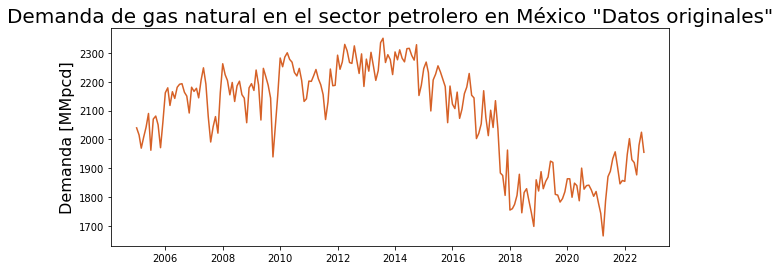

In [3]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_petrolero_original, color='#D66127')
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector petrolero en sus compoentes de Tendencia, Estacionalidad y Residual

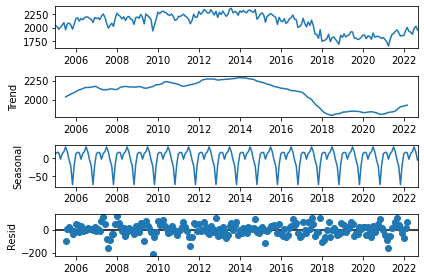

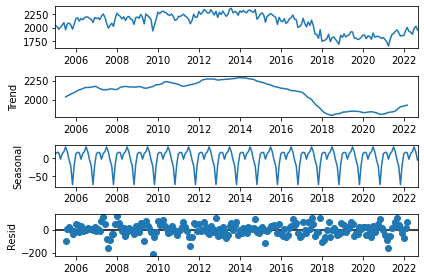

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_petrolero_original_seasonal_decomposition = seasonal_decompose(csv_demanda_petrolero_original)
csv_demanda_petrolero_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector petrolero en data de train y test

In [5]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_petrolero_original_train_data = csv_demanda_petrolero_original[:-num_test_points]
demanda_petrolero_original_test_data = csv_demanda_petrolero_original[-num_test_points:]

demanda_petrolero_original_train_data

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


Se grafica la distribución de la data "original" de TRAIN de Demanda en sector petrolero

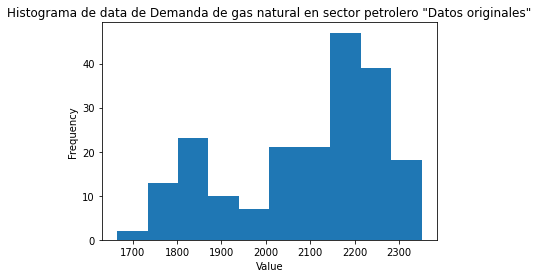

In [6]:
# Generate the histogram
plt.hist(demanda_petrolero_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos originales"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos originales de TRAIN de Demanda en sector petrolero

In [7]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_original_train_data.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.202047251153015
p-value: 4.1037526656295675e-05


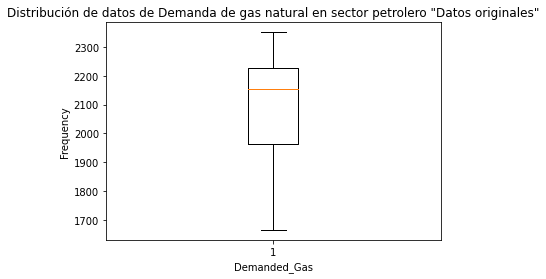

In [8]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
n_input = 24

data = demanda_petrolero_original_train_data['Demanded_Gas'].values
targets = data 

demanda_petrolero_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [11]:
demanda_petrolero_original_train_generator[0]

(array([[2039.88, 2015.25, 1969.51, 2008.19, 2041.86, 2089.82, 1962.26,
         2070.46, 2080.82, 2050.56, 1971.14, 2059.68, 2161.66, 2178.75,
         2117.61, 2165.25, 2142.03, 2180.68, 2191.06, 2193.12, 2163.43,
         2150.04, 2091.42, 2180.87]]),
 array([2166.37]))

In [12]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_original_train_data)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_original_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector petrolero

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [13]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [15]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_sin_tratamiento = Sequential()
model_LSTM_petrolero_sin_tratamiento.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_sin_tratamiento.add(Dense(1))
model_LSTM_petrolero_sin_tratamiento.compile(optimizer='adam', loss='mse')

In [16]:
model_LSTM_petrolero_sin_tratamiento.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo LSTM

In [17]:
model_LSTM_petrolero_sin_tratamiento.fit(demanda_petrolero_original_train_generator, epochs=15)


Epoch 1/15
177/177 [==============================] - 4s 7ms/step - loss: 1070825.5000
Epoch 2/15
177/177 [==============================] - 1s 6ms/step - loss: 478508.7812
Epoch 3/15
177/177 [==============================] - 1s 6ms/step - loss: 29820.7910
Epoch 4/15
177/177 [==============================] - 1s 7ms/step - loss: 14911.8662
Epoch 5/15
177/177 [==============================] - 1s 6ms/step - loss: 14743.3545
Epoch 6/15
177/177 [==============================] - 1s 6ms/step - loss: 16086.4307
Epoch 7/15
177/177 [==============================] - 1s 6ms/step - loss: 14051.3955
Epoch 8/15
177/177 [==============================] - 1s 7ms/step - loss: 16163.8135
Epoch 9/15
177/177 [==============================] - 1s 6ms/step - loss: 12481.8818
Epoch 10/15
177/177 [==============================] - 1s 7ms/step - loss: 15000.3535
Epoch 11/15
177/177 [==============================] - 1s 7ms/step - loss: 13182.7891
Epoch 12/15
177/177 [==============================] - 1s 7m

Se grafica la perdida por epoch

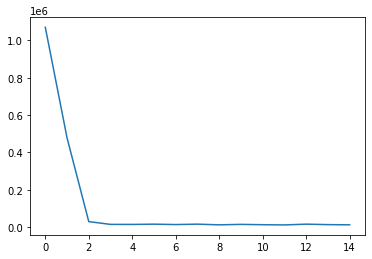

In [18]:
loss_per_epoch_model_FF = model_LSTM_petrolero_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [19]:
data = demanda_petrolero_original_train_data['Demanded_Gas'].values

demanda_petrolero_train_batch_sin_tratamiento = data[-n_input:]

demanda_petrolero_train_batch_sin_tratamiento

array([1782.6 , 1794.63, 1818.35, 1863.28, 1863.28, 1799.17, 1848.19,
       1839.68, 1786.97, 1900.31, 1827.31, 1839.67, 1841.23, 1824.71,
       1802.58, 1819.26, 1778.16, 1743.17, 1665.17, 1785.32, 1870.67,
       1889.2 , 1933.02, 1956.84])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [20]:
demanda_petrolero_train_batch_sin_tratamiento_reshaped = demanda_petrolero_train_batch_sin_tratamiento.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_sin_tratamiento_reshaped

array([[[1782.6 ],
        [1794.63],
        [1818.35],
        [1863.28],
        [1863.28],
        [1799.17],
        [1848.19],
        [1839.68],
        [1786.97],
        [1900.31],
        [1827.31],
        [1839.67],
        [1841.23],
        [1824.71],
        [1802.58],
        [1819.26],
        [1778.16],
        [1743.17],
        [1665.17],
        [1785.32],
        [1870.67],
        [1889.2 ],
        [1933.02],
        [1956.84]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [21]:
model_LSTM_petrolero_sin_tratamiento.predict(demanda_petrolero_train_batch_sin_tratamiento_reshaped)

1/1 [==============================] - 0s 292ms/step


array([[1700.2192]], dtype=float32)

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [22]:
demanda_petrolero_original_test_data['Demanded_Gas'].values[0]

1904.21

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [23]:
n_input = 24
n_features = 1

In [24]:
test_predictions_model_LSTM_petrolero_sin_pretratamiento = []

first_eval_batch = demanda_petrolero_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_sin_tratamiento.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [25]:
test_predictions_model_LSTM_petrolero_sin_pretratamiento

[array([1700.2192], dtype=float32),
 array([1697.6531], dtype=float32),
 array([1695.1713], dtype=float32),
 array([1691.7805], dtype=float32),
 array([1680.0435], dtype=float32),
 array([1673.906], dtype=float32),
 array([1670.8096], dtype=float32),
 array([1665.1733], dtype=float32),
 array([1662.3112], dtype=float32),
 array([1659.9148], dtype=float32),
 array([1665.8958], dtype=float32),
 array([1649.5789], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM sin la data pretratada

Text(0, 0.5, 'Demanda [MMpcd]')

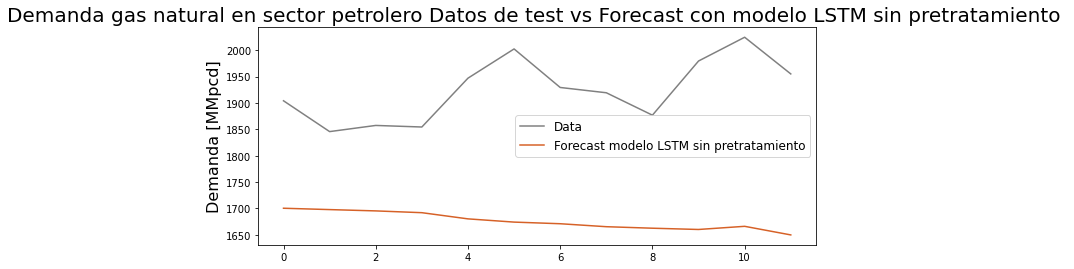

In [26]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_sin_pretratamiento, color='#D66127')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector petrolero Datos de test vs Forecast con modelo LSTM sin pretratamiento ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo LSTM sin la data pretratada

In [27]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_petrolero_sin_pretratamiento = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_sin_pretratamiento)
RMSE_predictions_model_LSTM_petrolero_sin_pretratamiento= np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_sin_pretratamiento))

print('MAPE:', MAPE_predictions_model_LSTM_petrolero_sin_pretratamiento)
print('RMSE:', RMSE_predictions_model_LSTM_petrolero_sin_pretratamiento)

MAPE: 0.12830343332781258
RMSE: 257.83845872392317


## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [28]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [29]:
outlier_threshold = 1.1

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [30]:
demanda_petrolero_original_train_para_tratamiento =demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


In [31]:
demanda_petrolero_train_pretratamiento_media = remove_replace_outliers_media(demanda_petrolero_original_train_para_tratamiento['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_media.tail(10)

Date
2020-12-01    1802.5800
2021-01-01    1819.2600
2021-02-01    1778.1600
2021-03-01    1743.1700
2021-04-01    2094.9368
2021-05-01    1785.3200
2021-06-01    1870.6700
2021-07-01    1889.2000
2021-08-01    1933.0200
2021-09-01    1956.8400
Name: Demanded_Gas, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

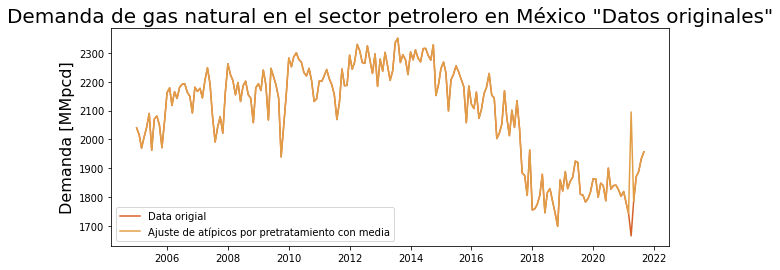

In [32]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original_train_data, color='#D66127')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#E29E46')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de media artimetica de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

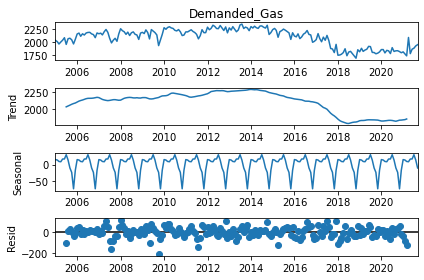

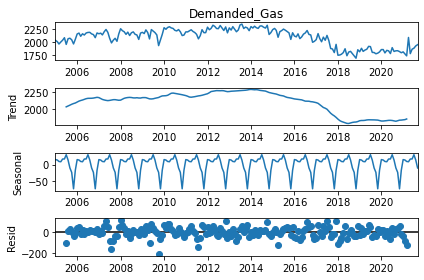

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_petrolero_train_pretratamiento_media_seasonal_decomposition = seasonal_decompose(demanda_petrolero_train_pretratamiento_media)
demanda_petrolero_train_pretratamiento_media_seasonal_decomposition.plot()

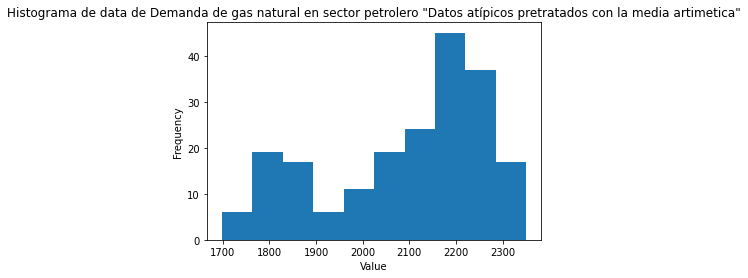

In [34]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector petrolero para el caso de pretratamiento con la media artimetica

In [35]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.123739937957446
p-value: 4.2676165909916186e-05


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

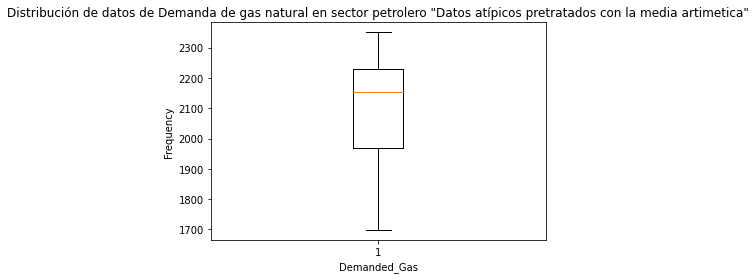

In [36]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [37]:
n_input = 24

data = demanda_petrolero_train_pretratamiento_media
targets = data 

demanda_petrolero_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [38]:
demanda_petrolero_train_generator_pretratamiento_media[0]

(array([[2039.88, 2015.25, 1969.51, 2008.19, 2041.86, 2089.82, 1962.26,
         2070.46, 2080.82, 2050.56, 1971.14, 2059.68, 2161.66, 2178.75,
         2117.61, 2165.25, 2142.03, 2180.68, 2191.06, 2193.12, 2163.43,
         2150.04, 2091.42, 2180.87]]),
 array([2166.37]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [39]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_media)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_media))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [40]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [41]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_pretratamiento_media = Sequential()
model_LSTM_petrolero_pretratamiento_media.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretratamiento_media.add(Dense(1))
model_LSTM_petrolero_pretratamiento_media.compile(optimizer='adam', loss='mse')

In [42]:
model_LSTM_petrolero_pretratamiento_media.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [43]:
model_LSTM_petrolero_pretratamiento_media.fit(demanda_petrolero_train_generator_pretratamiento_media, epochs=15)

Epoch 1/15
177/177 [==============================] - 3s 7ms/step - loss: 1267285.1250
Epoch 2/15
177/177 [==============================] - 1s 7ms/step - loss: 409170.5312
Epoch 3/15
177/177 [==============================] - 1s 6ms/step - loss: 386770.0000
Epoch 4/15
177/177 [==============================] - 1s 6ms/step - loss: 15196.1992
Epoch 5/15
177/177 [==============================] - 1s 6ms/step - loss: 13735.9521
Epoch 6/15
177/177 [==============================] - 1s 6ms/step - loss: 14064.4326
Epoch 7/15
177/177 [==============================] - 1s 7ms/step - loss: 16846.8398
Epoch 8/15
177/177 [==============================] - 1s 6ms/step - loss: 16466.3867
Epoch 9/15
177/177 [==============================] - 1s 7ms/step - loss: 16424.0645
Epoch 10/15
177/177 [==============================] - 1s 6ms/step - loss: 17192.4629
Epoch 11/15
177/177 [==============================] - 1s 6ms/step - loss: 16184.4521
Epoch 12/15
177/177 [==============================] - 1s 6

Se grafica la perdida por epoch 

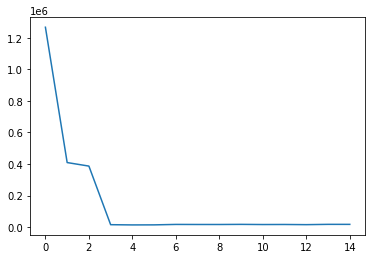

In [44]:
loss_per_epoch = model_LSTM_petrolero_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [45]:
demanda_petrolero_train_batch_pretratamiento_media = demanda_petrolero_train_pretratamiento_media.values[-n_input:]


demanda_petrolero_train_batch_pretratamiento_media

array([1782.6   , 1794.63  , 1818.35  , 1863.28  , 1863.28  , 1799.17  ,
       1848.19  , 1839.68  , 1786.97  , 1900.31  , 1827.31  , 1839.67  ,
       1841.23  , 1824.71  , 1802.58  , 1819.26  , 1778.16  , 1743.17  ,
       2094.9368, 1785.32  , 1870.67  , 1889.2   , 1933.02  , 1956.84  ])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [46]:
demanda_petrolero_train_batch_pretratamiento_media_reshaped = demanda_petrolero_train_batch_pretratamiento_media.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_media_reshaped

array([[[1782.6   ],
        [1794.63  ],
        [1818.35  ],
        [1863.28  ],
        [1863.28  ],
        [1799.17  ],
        [1848.19  ],
        [1839.68  ],
        [1786.97  ],
        [1900.31  ],
        [1827.31  ],
        [1839.67  ],
        [1841.23  ],
        [1824.71  ],
        [1802.58  ],
        [1819.26  ],
        [1778.16  ],
        [1743.17  ],
        [2094.9368],
        [1785.32  ],
        [1870.67  ],
        [1889.2   ],
        [1933.02  ],
        [1956.84  ]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [47]:
model_LSTM_petrolero_pretratamiento_media.predict(demanda_petrolero_train_batch_pretratamiento_media_reshaped)

1/1 [==============================] - 0s 200ms/step


array([[1828.5308]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [48]:
n_input = 24
n_features = 1

In [49]:
test_predictions_model_LSTM_petrolero_pretratamiento_media  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_media.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


In [50]:
test_predictions_model_LSTM_petrolero_pretratamiento_media

[array([1828.5308], dtype=float32),
 array([1880.4752], dtype=float32),
 array([1866.1345], dtype=float32),
 array([1835.9926], dtype=float32),
 array([1886.1893], dtype=float32),
 array([1850.9866], dtype=float32),
 array([1864.5596], dtype=float32),
 array([1865.513], dtype=float32),
 array([1843.0643], dtype=float32),
 array([1846.6384], dtype=float32),
 array([1841.3992], dtype=float32),
 array([1842.0657], dtype=float32)]

In [51]:
demanda_petrolero_original_test_data['Demanded_Gas'].values

array([1904.21, 1845.7 , 1857.4 , 1854.42, 1947.12, 2002.63, 1929.47,
       1919.43, 1876.88, 1979.7 , 2024.82, 1955.19])

Text(0, 0.5, 'Demanda [MMpcd]')

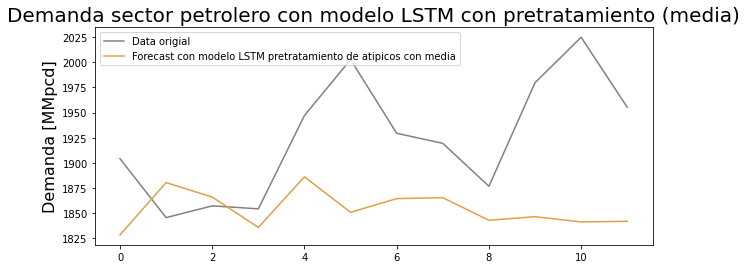

In [52]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#E29E46')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media'))

plt.title('Demanda sector petrolero con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [53]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media)
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media)

MAPE: 0.039637098051743466
RMSE: 94.19413026119324


Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

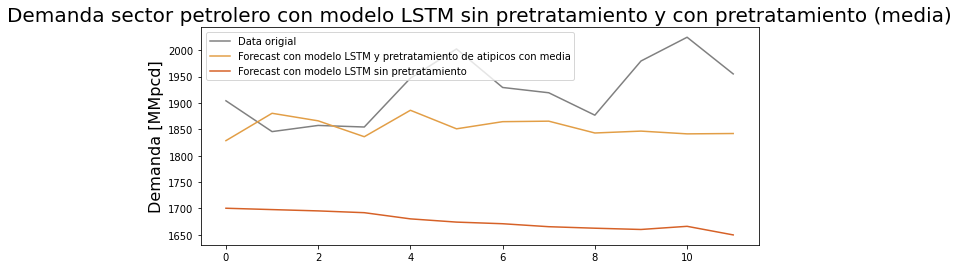

In [54]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media  , color='#E29E46')
plt.plot(test_predictions_model_LSTM_petrolero_sin_pretratamiento, color='#D66127')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector petrolero con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [55]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [56]:
outlier_threshold = 1.1

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [57]:
demanda_petrolero_original_train_para_tratamiento2 = demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


In [58]:
demanda_petrolero_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_petrolero_original_train_para_tratamiento2['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_mediana.tail(10)

Date
2020-12-01    1802.580
2021-01-01    1819.260
2021-02-01    1778.160
2021-03-01    1743.170
2021-04-01    2154.035
2021-05-01    1785.320
2021-06-01    1870.670
2021-07-01    1889.200
2021-08-01    1933.020
2021-09-01    1956.840
Name: Demanded_Gas, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

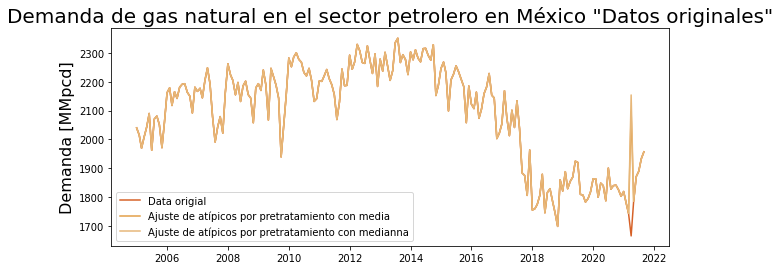

In [59]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original_train_data, color='#D66127')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#E29E46')
plt.plot(demanda_petrolero_train_pretratamiento_mediana,  color='#E7B779')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con medianna'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

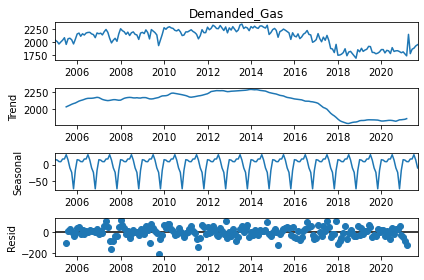

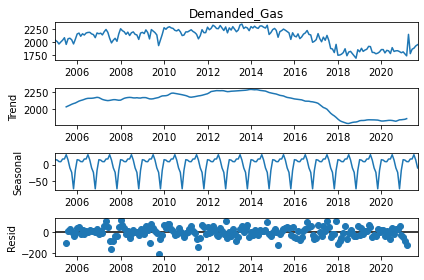

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_petrolero_train_pretratamiento_mediana)
demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition.plot()


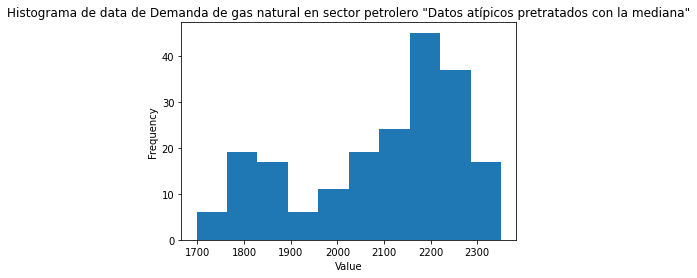

In [61]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [62]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.289644016992085
p-value: 3.927894204602822e-05


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [63]:
n_input = 24

data = demanda_petrolero_train_pretratamiento_mediana
targets = data 

demanda_petrolero_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_petrolero_train_generator_pretratamiento_mediana[0]

(array([[2039.88, 2015.25, 1969.51, 2008.19, 2041.86, 2089.82, 1962.26,
         2070.46, 2080.82, 2050.56, 1971.14, 2059.68, 2161.66, 2178.75,
         2117.61, 2165.25, 2142.03, 2180.68, 2191.06, 2193.12, 2163.43,
         2150.04, 2091.42, 2180.87]]),
 array([2166.37]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [64]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [65]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [66]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_pretratamiento_mediana = Sequential()

model_LSTM_petrolero_pretratamiento_mediana.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretratamiento_mediana.add(Dense(1))
model_LSTM_petrolero_pretratamiento_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_petrolero_pretratamiento_mediana.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se entrena el modelo 

In [67]:
model_LSTM_petrolero_pretratamiento_mediana.fit(demanda_petrolero_train_generator_pretratamiento_mediana, epochs=15)

Epoch 1/15


177/177 [==============================] - 3s 7ms/step - loss: 1523198.5000
Epoch 2/15
177/177 [==============================] - 1s 7ms/step - loss: 167719.5156
Epoch 3/15
177/177 [==============================] - 1s 6ms/step - loss: 15700.5420
Epoch 4/15
177/177 [==============================] - 1s 7ms/step - loss: 13681.6104
Epoch 5/15
177/177 [==============================] - 1s 6ms/step - loss: 13370.1748
Epoch 6/15
177/177 [==============================] - 1s 7ms/step - loss: 13008.2510
Epoch 7/15
177/177 [==============================] - 1s 6ms/step - loss: 13625.3076
Epoch 8/15
177/177 [==============================] - 1s 6ms/step - loss: 14723.7725
Epoch 9/15
177/177 [==============================] - 1s 6ms/step - loss: 14613.9658
Epoch 10/15
177/177 [==============================] - 1s 6ms/step - loss: 14033.6113
Epoch 11/15
177/177 [==============================] - 1s 6ms/step - loss: 13156.6172
Epoch 12/15
177/177 [==============================] - 1s 7ms/step - lo

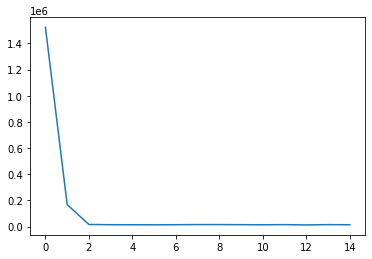

In [68]:
loss_per_epoch = model_LSTM_petrolero_pretratamiento_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [69]:
demanda_petrolero_train_batch_pretratamiento_mediana = demanda_petrolero_train_pretratamiento_mediana.values[-n_input:]


demanda_petrolero_train_batch_pretratamiento_mediana

array([1782.6  , 1794.63 , 1818.35 , 1863.28 , 1863.28 , 1799.17 ,
       1848.19 , 1839.68 , 1786.97 , 1900.31 , 1827.31 , 1839.67 ,
       1841.23 , 1824.71 , 1802.58 , 1819.26 , 1778.16 , 1743.17 ,
       2154.035, 1785.32 , 1870.67 , 1889.2  , 1933.02 , 1956.84 ])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [70]:
demanda_petrolero_train_batch_pretratamiento_mediana_reshaped = demanda_petrolero_train_batch_pretratamiento_mediana.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_mediana_reshaped

array([[[1782.6  ],
        [1794.63 ],
        [1818.35 ],
        [1863.28 ],
        [1863.28 ],
        [1799.17 ],
        [1848.19 ],
        [1839.68 ],
        [1786.97 ],
        [1900.31 ],
        [1827.31 ],
        [1839.67 ],
        [1841.23 ],
        [1824.71 ],
        [1802.58 ],
        [1819.26 ],
        [1778.16 ],
        [1743.17 ],
        [2154.035],
        [1785.32 ],
        [1870.67 ],
        [1889.2  ],
        [1933.02 ],
        [1956.84 ]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [71]:
model_LSTM_petrolero_pretratamiento_mediana.predict(demanda_petrolero_train_batch_pretratamiento_mediana_reshaped)

1/1 [==============================] - 0s 290ms/step


array([[1819.9774]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [72]:
n_input = 24
n_features = 1

In [73]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_mediana.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretratamiento_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


In [74]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana

[array([1819.9774], dtype=float32),
 array([1827.0149], dtype=float32),
 array([1806.4297], dtype=float32),
 array([1834.0634], dtype=float32),
 array([1835.2506], dtype=float32),
 array([1890.7037], dtype=float32),
 array([1831.7186], dtype=float32),
 array([1762.4103], dtype=float32),
 array([1823.1366], dtype=float32),
 array([1839.2772], dtype=float32),
 array([1835.0315], dtype=float32),
 array([1873.8594], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

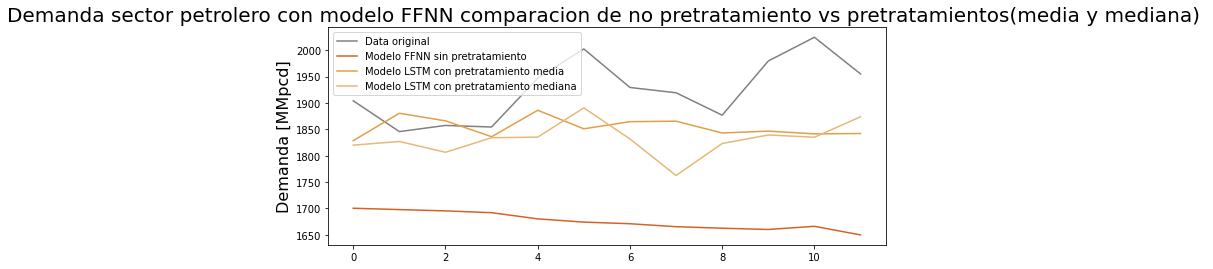

In [75]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_sin_pretratamiento,  color='#D66127')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#E29E46')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_mediana ,  color='#E7B779')
plt.legend(('Data original', 'Modelo FFNN sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector petrolero con modelo FFNN comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [76]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana )
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana ))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)

MAPE: 0.04779023778796251
RMSE: 106.04663181809246
